![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 3 - Deep Learning Basics</center>
### <center> Back-propagation (forward and backwrad)</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/03_Backpropagation/Backpropagation.ipynb)

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

# np.random.seed(1)

### Get MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml

mX, vY = fetch_openml('mnist_784', version=1, return_X_y=True)
vY     = vY.astype(int)

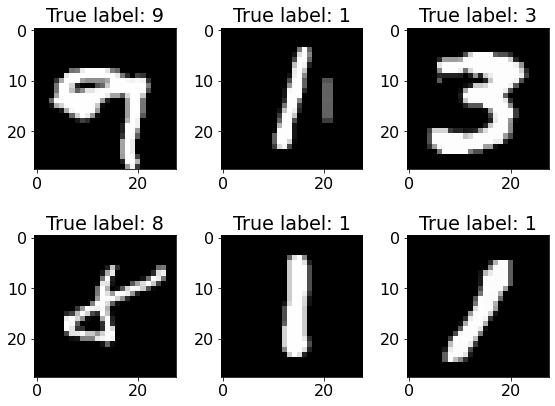

((70000, 784), (70000,))

In [3]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(8,6))
for ax in fig.axes:
    idx = np.random.randint(0, N)
    ax.imshow(np.reshape(mX[idx,:], (28, 28)), cmap='gray')
    ax.set_title('True label: ' + str(vY[idx]))
    
plt.tight_layout()
plt.show()

mX.shape, vY.shape

###  Construct the different layers
Each layer should have a `Forward` method and a `Backward` method

#### Affine (linear) layer
Forward:
$$\boldsymbol{z}=\boldsymbol{W}\boldsymbol{x}+\boldsymbol{b}$$

Gradients:
$$\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{b}}\boldsymbol{z}\left[\boldsymbol{h}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{z}}L,\boldsymbol{h}\right\rangle $$
$$\implies\boxed{\nabla_{\boldsymbol{b}}L=\nabla_{\boldsymbol{z}}L}$$
  

$$\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{x}}\boldsymbol{z}\left[\boldsymbol{h}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{x}}L,\boldsymbol{W}\boldsymbol{h}\right\rangle =\left\langle \boldsymbol{W}^{T}\nabla_{\boldsymbol{x}}L,\boldsymbol{h}\right\rangle $$
$$\implies\boxed{\nabla_{\boldsymbol{x}}L=\boldsymbol{W}^{T}\nabla_{\boldsymbol{z}}L}$$

$$\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{W}}\boldsymbol{z}\left[\boldsymbol{H}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{x}}L,\boldsymbol{H}\boldsymbol{x}\right\rangle =\left\langle \nabla_{\boldsymbol{W}}L\boldsymbol{x}^{T},\boldsymbol{H}\right\rangle $$
$$\implies\boxed{\nabla_{\boldsymbol{W}}L=\nabla_{\boldsymbol{z}}L\boldsymbol{x}^{T}}$$

In [4]:
class LinearLayer:
    def __init__(self, dIn, dOut):
        mW = np.random.randn(dOut, dIn) / dIn
        vB = np.zeros(dOut)
        
        self.dParams = {'mW' : mW, 'vB': vB}
        self.dGrads  = {}
        
    def Forward(self, mX):
        mW      = self.dParams['mW']
        vB      = self.dParams['vB']
        self.mX = mX                   #-- store for Backward
        mZ      = mW @ mX + vB[:,None]
        
        return mZ
    
    def Backward(self, mDz):
        mW  = self.dParams['mW']
        
        vDb = mDz.sum(axis=1)
        mDw = mDz @ self.mX.T
        mDx = mW.T @ mDz
        
        self.dGrads['vB'] = vDb
        self.dGrads['mW'] = mDw
                
        return mDx

#### ReLU Layer
Forward:
$$\boldsymbol{z}=\text{ReLU}\left(\boldsymbol{x}\right)=\max\left\{ \boldsymbol{x},0\right\} $$

Gradient:
$$\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{x}}\boldsymbol{z}\left[\boldsymbol{h}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{z}}L,\text{diag}\left(\mathbb{I}_{\boldsymbol{x}>0}\right)\boldsymbol{h}\right\rangle =\left\langle \text{diag}\left(\mathbb{I}_{\boldsymbol{x}>0}\right)\nabla_{\boldsymbol{z}}L,\boldsymbol{h}\right\rangle $$
$$\implies\boxed{\nabla_{\boldsymbol{x}}L=\text{diag}\left(\mathbb{I}_{\boldsymbol{x}>0}\right)\nabla_{\boldsymbol{z}}L}$$

In [5]:
class ReLULayer:
    def __init__(self):
        self.dGrads = {}
    
    def Forward(self, mX):
        self.mX = mX                 #-- store for Backward
        mZ      = np.maximum(mX, 0)
        
        return mZ
    
    def Backward(self, mDz):
        mX    = self.mX
        mMask = (mX > 0).astype(float)
        
        mDx   = mDz * mMask
                
        return mDx

#### It is efficient to combine the Softmax layer with the cross entropy loss

### Generic model:
The model is simply a list of layers

In [6]:
class Model:
    def __init__(self, lLayers):
        self.lLayers = lLayers
        
    def Forward(self, mX):
        for oLayer in self.lLayers:
            mX = oLayer.Forward(mX)
        return mX
    
    def Backward(self, mDz):
        for oLayer in reversed(self.lLayers):
            mDz = oLayer.Backward(mDz)

###  Loss function (Cross entropy + Softmax)
$$\ell\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\boldsymbol{y}_{i}^{T}\log\left(\hat{\boldsymbol{y}}_{i}\right)$$
where
$$\hat{\boldsymbol{y}}=\text{softmax}\left(\boldsymbol{z}\right)=\frac{\exp\left(\boldsymbol{z}\right)}{\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)}$$

Gradient:  
First, we note that
\begin{align*}
\ell\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right) & =-\boldsymbol{y}_{i}^{T}\log\left(\hat{\boldsymbol{y}}_{i}\right)\\
 & =-\boldsymbol{y}_{i}^{T}\log\left(\frac{\exp\left(\boldsymbol{z}\right)}{\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)}\right)\\
 & =-\boldsymbol{y}_{i}^{T}\left(\log\left(\exp\left(\boldsymbol{z}\right)\right)-\boldsymbol{1}\log\left(\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)\right)\right)\\
 & =-\boldsymbol{y}_{i}^{T}\boldsymbol{z}+\log\left(\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)\right)
\end{align*}

Hence:   
\begin{align*}
\nabla_{\boldsymbol{z}}\ell\left(\boldsymbol{z}\right)\left[\boldsymbol{h}\right] & =-\boldsymbol{y}_{i}^{T}\boldsymbol{h}+\nabla_{\boldsymbol{z}}\log\left(\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)\right)\left[\boldsymbol{h}\right]\\
 & =-\boldsymbol{y}_{i}^{T}\boldsymbol{h}+\frac{1}{\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)}\nabla\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)\left[\boldsymbol{h}\right]\\
 & =-\boldsymbol{y}_{i}^{T}\boldsymbol{h}+\frac{1}{\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)}\exp\left(\boldsymbol{z}^{T}\right)\boldsymbol{h}\\
 & =-\boldsymbol{y}_{i}^{T}\boldsymbol{h}+\hat{\boldsymbol{y}}_{i}\boldsymbol{h}\\
 & =\left\langle \hat{\boldsymbol{y}}_{i}-\boldsymbol{y}_{i},\boldsymbol{h}\right\rangle 
\end{align*}

$$\implies\boxed{\nabla_{\boldsymbol{z}}\ell=\hat{\boldsymbol{y}}_{i}-\boldsymbol{y}_{i}}$$

#### Overall loss:
$$L=\frac{1}{N}\sum_{i=1}^{N}\ell_{i}=\frac{1}{N}\sum_{i=1}^{N}\ell\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)$$

In [7]:
def CrossEntropyLoss(vY, mZ):
    '''
    Returns both the loss and the gradient w.r.t the input (mZ)
    '''
    mHatY  = np.exp(mZ)
    mHatY /= np.sum(mHatY, axis=0)
    N      = len(vY)
    loss   = -np.log(mHatY[vY,range(N)]).mean()
    
    mDz               = mHatY
    mDz[vY,range(N)] -= 1
    mDz              /= N
    
    return loss, mDz

###  Split to train and test:

In [8]:
from sklearn.model_selection import train_test_split

Ntrain  = 60000
Ntest   = 10000
vIdx    = np.random.choice(N, Ntrain + Ntest)
mX      = mX[vIdx,:]
vY      = vY[vIdx]

mTrainX, mTestX, vTrainY, vTestY = train_test_split(mX, vY, train_size=Ntrain, test_size=Ntest)

(mTrainX.shape, 
vTrainY.shape, 
mTestX.shape,  
vTestY.shape)

((60000, 784), (60000,), (10000, 784), (10000,))

In [9]:
def TrainModel(oModel, mX, vY, numIter, learningRate):
    fig   = plt.figure()
    vLoss = np.full(numIter, np.nan)
   
    for ii in range(numIter):

        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (vanila gradient descnet)
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]

        #-- Display:
        vLoss[ii] = loss
        print('Iteration: ', ii, '. loss = ', loss, '\r', end='')
        plt.cla()
        plt.plot(vLoss)
        plt.xlabel('Iterations')
        plt.ylabel('Training loss')
        fig.canvas.draw()
        plt.pause(1e-20)

### Train a shallow model:

<IPython.core.display.Javascript object>


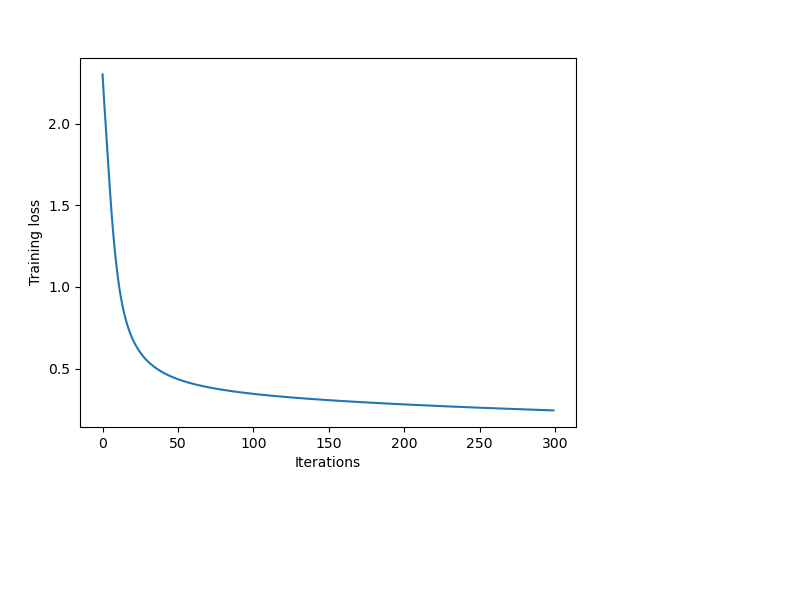

In [10]:
%matplotlib notebook

oModel = Model([
        LinearLayer(784, 200),
        ReLULayer(),
        LinearLayer(200, 10),
])

TrainModel(oModel, mTrainX.T, vTrainY, 300, 1e-3)

###  Check model performance:

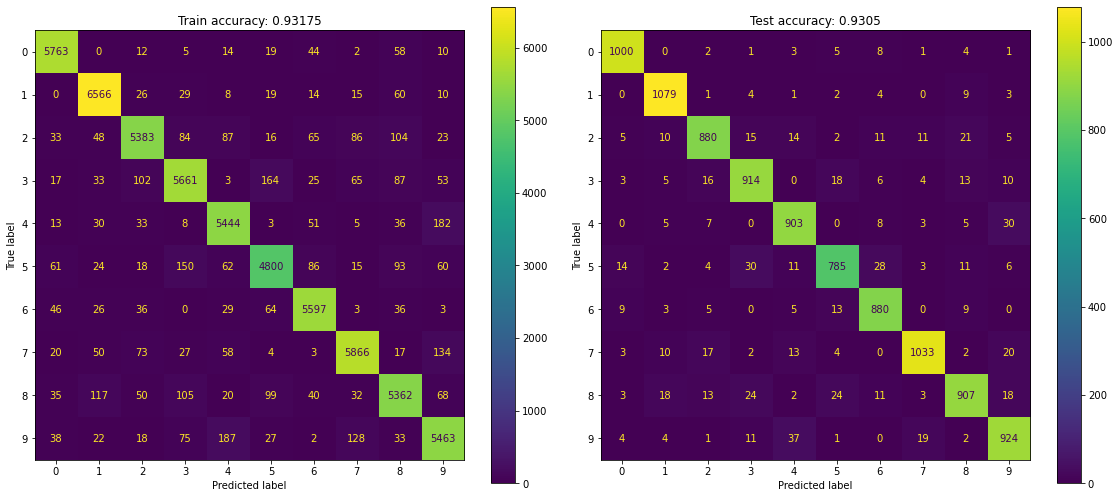

In [11]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#-- Apply model to data:
mHatTrainY = oModel.Forward(mTrainX.T)
mHatTestY  = oModel.Forward(mTestX.T)
vHatTrainY = np.argmax(mHatTrainY, axis=0)
vHatTestY  = np.argmax(mHatTestY,  axis=0)

#-- Plot condusion matrices:
mTrainConfusion = confusion_matrix(vTrainY, vHatTrainY)
mTestConfusion  = confusion_matrix(vTestY,  vHatTestY)

_, ax = plt.subplots(1, 2, figsize=(16,7))
ConfusionMatrixDisplay(mTrainConfusion, display_labels=range(10)).plot(values_format='g', ax=ax[0])
ConfusionMatrixDisplay(mTestConfusion,  display_labels=range(10)).plot(values_format='g', ax=ax[1])
ax[0].set_title('Train accuracy: ' + str(np.mean(vTrainY == vHatTrainY)))
ax[1].set_title('Test accuracy: '  + str(np.mean(vTestY  == vHatTestY)))
plt.tight_layout()
plt.show()

### Train a deeper model:

<IPython.core.display.Javascript object>


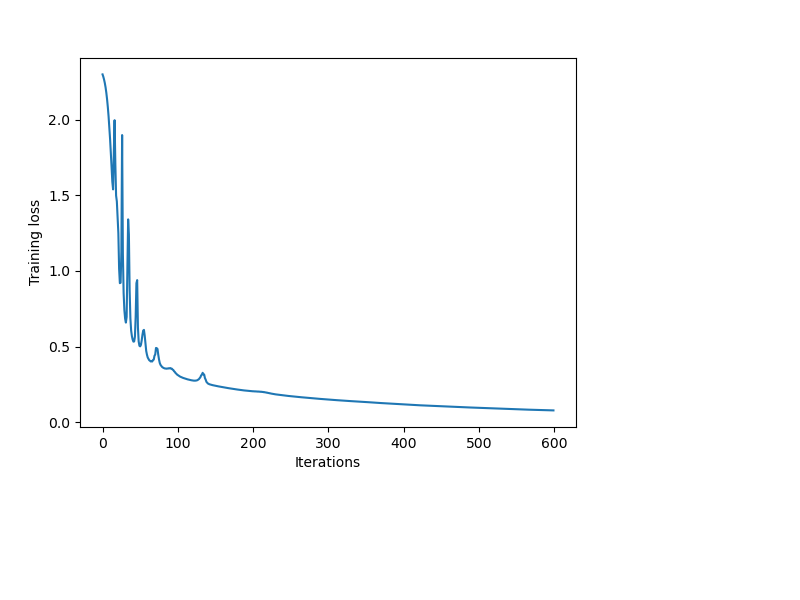

In [12]:
%matplotlib notebook

oModel = Model([
        LinearLayer(784, 200),
        ReLULayer(),
        LinearLayer(200, 50),
        ReLULayer(),
        LinearLayer(50, 10),
])

TrainModel(oModel, mTrainX.T, vTrainY, 600, 1e-2)

###  Check model performance:

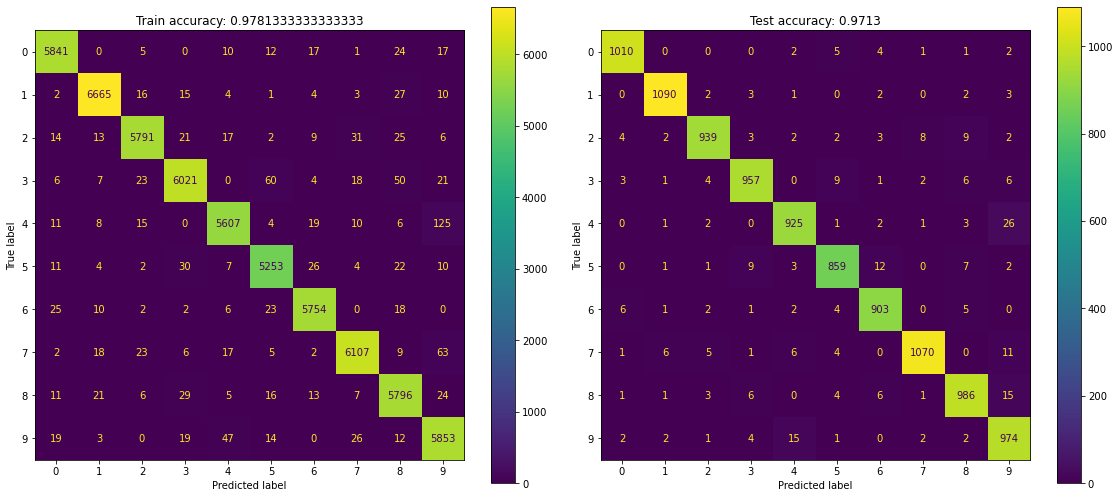

In [13]:
%matplotlib inline

#-- Apply model to data:
mHatTrainY = oModel.Forward(mTrainX.T)
mHatTestY  = oModel.Forward(mTestX.T)
vHatTrainY = np.argmax(mHatTrainY, axis=0)
vHatTestY  = np.argmax(mHatTestY,  axis=0)

#-- Plot condusion matrices:
mTrainConfusion = confusion_matrix(vTrainY, vHatTrainY)
mTestConfusion  = confusion_matrix(vTestY,  vHatTestY)

_, ax = plt.subplots(1, 2, figsize=(16,7))
ConfusionMatrixDisplay(mTrainConfusion, display_labels=range(10)).plot(values_format='g', ax=ax[0])
ConfusionMatrixDisplay(mTestConfusion,  display_labels=range(10)).plot(values_format='g', ax=ax[1])
ax[0].set_title('Train accuracy: ' + str(np.mean(vTrainY == vHatTrainY)))
ax[1].set_title('Test accuracy: '  + str(np.mean(vTestY  == vHatTestY)))
plt.tight_layout()
plt.show()

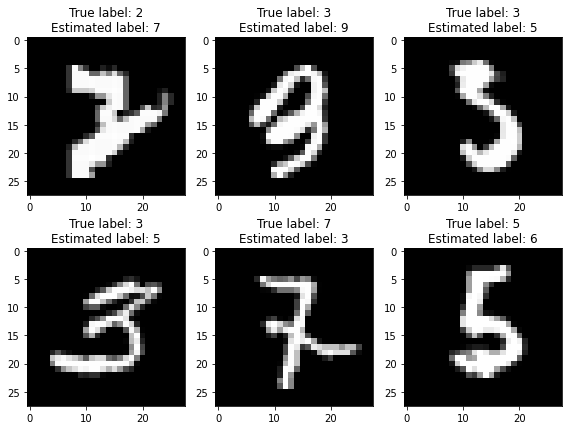

In [14]:
%matplotlib inline

#-- Apply model to data:
mHatTestY  = oModel.Forward(mTestX.T)
vHatTestY  = np.argmax(mHatTestY, axis=0)

vWrongIdx = np.nonzero(vTestY != vHatTestY)[0]

#-- Plot a few mistakes:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(8,6))
for ax in fig.axes:
    idx = vWrongIdx[np.random.randint(0, len(vWrongIdx))]
    ax.imshow(np.reshape(mTestX[idx,:], (28, 28)), cmap='gray')
    ax.set_title('True label: ' + str(vTestY[idx]) + '\nEstimated label: ' + str(vHatTestY[idx]))
    
plt.tight_layout()
plt.show()